In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
%cd ..

In [4]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [417]:
def create_blr_problem(dim, seed):
    if dim in [2, 5]:
        signal_std = 1e-3
    else:
        signal_std = 1e-1
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=1,
                            signal_std=signal_std,
                            num_targets=100,
                            seed=seed)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [418]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [945]:
def true_preds(blr_obj, seed=0):

    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [946]:
def var_approx_preds(blr_obj, seed=0):
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [947]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = dist.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [948]:
def make_gmm(preds, signal_std):
    mix = dist.Categorical(torch.ones((preds.shape[1],)))
    comp = dist.Independent(dist.Normal(loc=preds, scale=signal_std), 1)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

# Point Estimate Results

## MSE

In [1632]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 90
beamwidth = 1
emp = []
vari = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [1602]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [1603]:
exact_log_probs = make_gmm(true_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [1604]:
exact_var_log_probs = make_gmm(var_approx_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [1605]:
exact_var_log_probs

tensor([-2594.2487])

In [1606]:
exact_log_probs

tensor([-258.5638])

In [1607]:
vari_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [1608]:
var_gmm = make_gmm(vari_full_preds, signal_std=b.signal_std)
var_log_probs = var_gmm.log_prob(b.regression_targets_test)

In [1609]:
emp_gmm = make_gmm(emp_full_preds, signal_std=b.signal_std)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test)

In [1610]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=b.signal_std).log_prob(b.regression_targets_test))

In [1611]:
map_log_likelihood

tensor(-2765.3179)

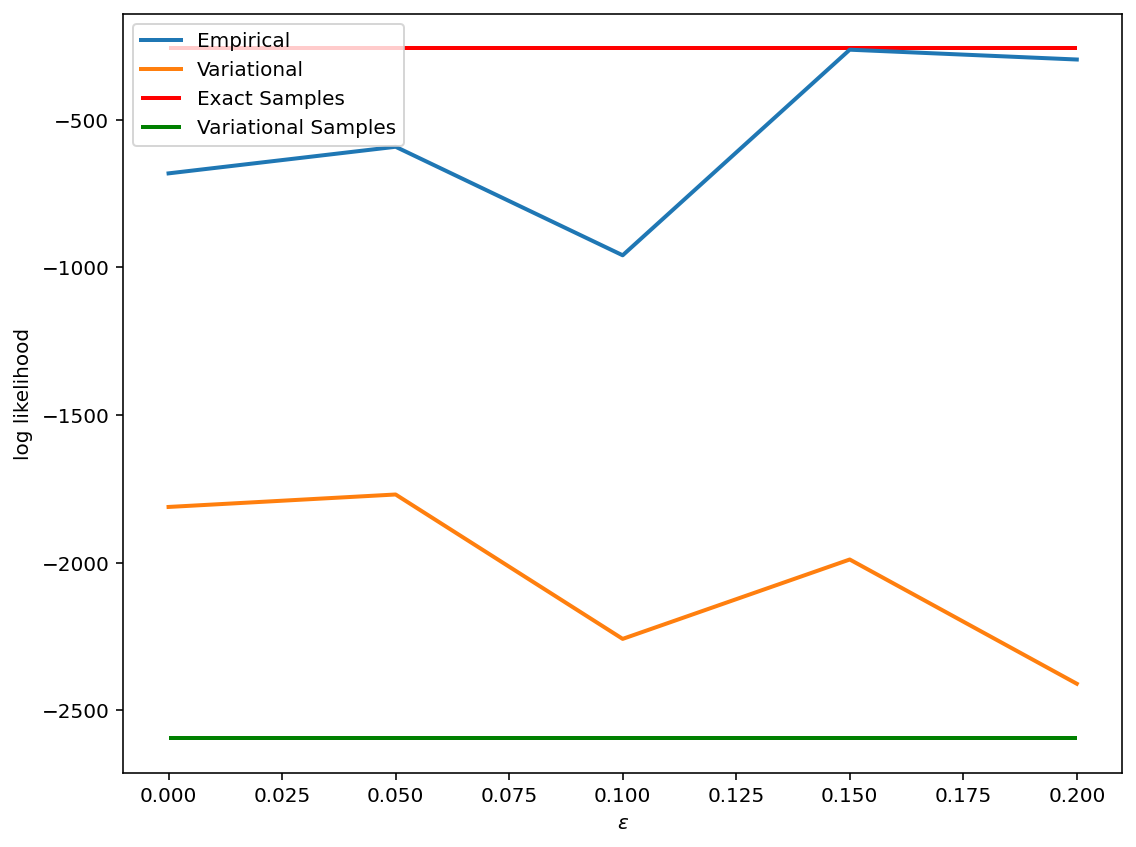

In [1612]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs, label='Empirical')
ax.plot(epsilons, var_log_probs, label='Variational')
ax.hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

# MSE

In [1613]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [1614]:
exact_rmse = torch.sqrt((exact_preds.mean(0) - b.regression_targets_test) ** 2 / exact_preds.var(0)).mean()

In [1615]:
var_rmse = torch.sqrt((var_preds.mean(0) - b.regression_targets_test) ** 2 / var_preds.var(0)).mean()

In [1616]:
emp_rmse = torch.sqrt((emp_full_preds.mean(1) - b.regression_targets_test) ** 2 / emp_full_preds.var(1)).mean(1)

In [1617]:
vari_rmse=torch.sqrt((vari_full_preds.mean(1) - b.regression_targets_test) ** 2 / vari_full_preds.var(1)).mean(1)

In [1618]:
emp_rmse

tensor([0.9740, 1.2614, 1.3814, 1.3096, 1.5070])

In [1619]:
((exact_preds.mean(0) - b.regression_targets_test) ** 2).sum() / ((b.regression_targets_test.mean() - b.regression_targets_test) ** 2).sum()

tensor(0.0916)

In [1620]:
((var_preds.mean(0) - b.regression_targets_test) ** 2).sum() / ((b.regression_targets_test.mean() - b.regression_targets_test) ** 2).sum()

tensor(0.1052)

In [1621]:
((emp_full_preds.mean(1) - b.regression_targets_test) ** 2).sum(1) / ((b.regression_targets_test.mean() - b.regression_targets_test) ** 2).sum()

tensor([0.0914, 0.1125, 0.1202, 0.0863, 0.1137])

In [1622]:
((vari_full_preds.mean(1) - b.regression_targets_test) ** 2).sum(1) / ((b.regression_targets_test.mean() - b.regression_targets_test) ** 2).sum()

tensor([0.1058, 0.1031, 0.1055, 0.1046, 0.1037])

In [1623]:
torch.sqrt((exact_preds.mean(0) - b.regression_targets_test) ** 2 / exact_preds.mea).mean()

AttributeError: 'Tensor' object has no attribute 'mea'

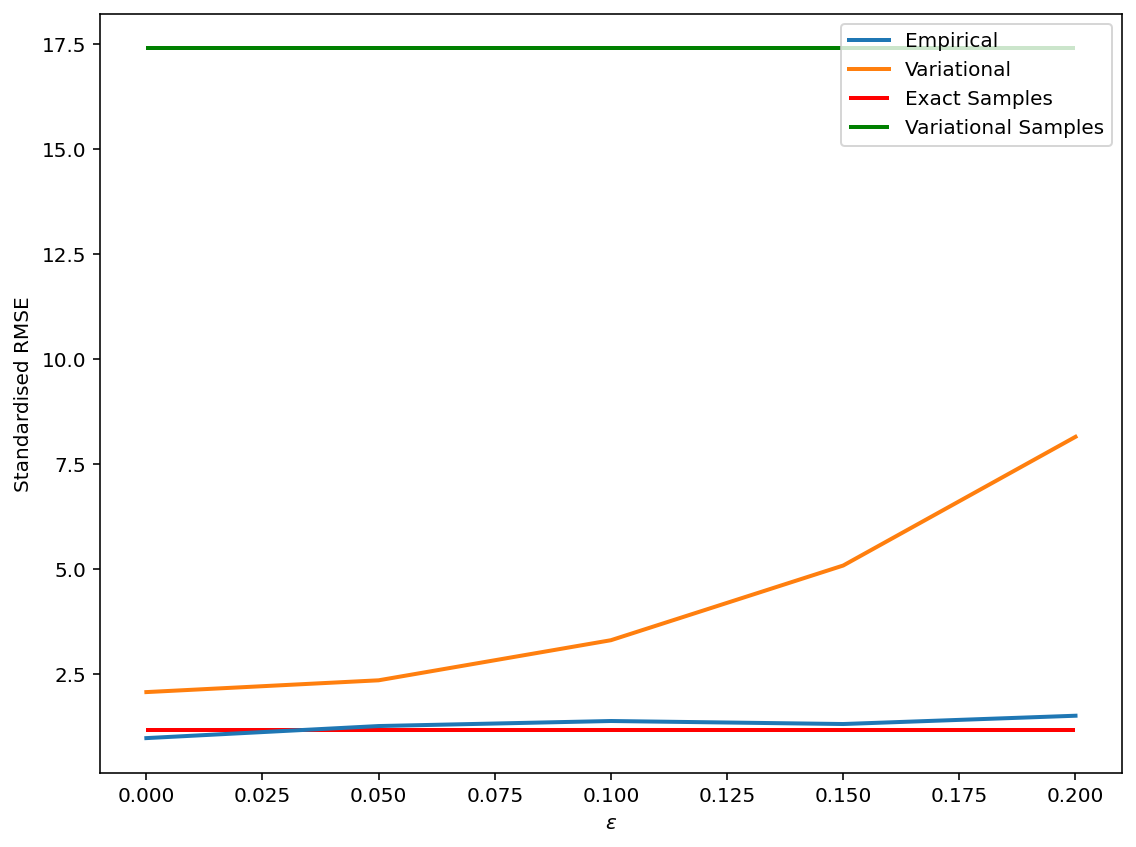

In [1624]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_rmse, label='Empirical')
ax.plot(epsilons, vari_rmse, label='Variational')
ax.hlines(exact_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised RMSE')
ax.legend()
fig.tight_layout()

# MAE

In [1625]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [1626]:
exact_mae = (torch.abs(exact_preds.mean(0) - b.regression_targets_test) / exact_preds.std(0)).mean()

In [1627]:
var_mae = (torch.abs(var_preds.mean(0) - b.regression_targets_test) / var_preds.std(0)).mean()

In [1628]:
emp_mae = (torch.abs(emp_full_preds.mean(1) - b.regression_targets_test) / emp_full_preds.std(1)).mean(1)

In [1629]:
vari_mae = (torch.abs(vari_full_preds.mean(1) - b.regression_targets_test) / vari_full_preds.std(1)).mean(1)

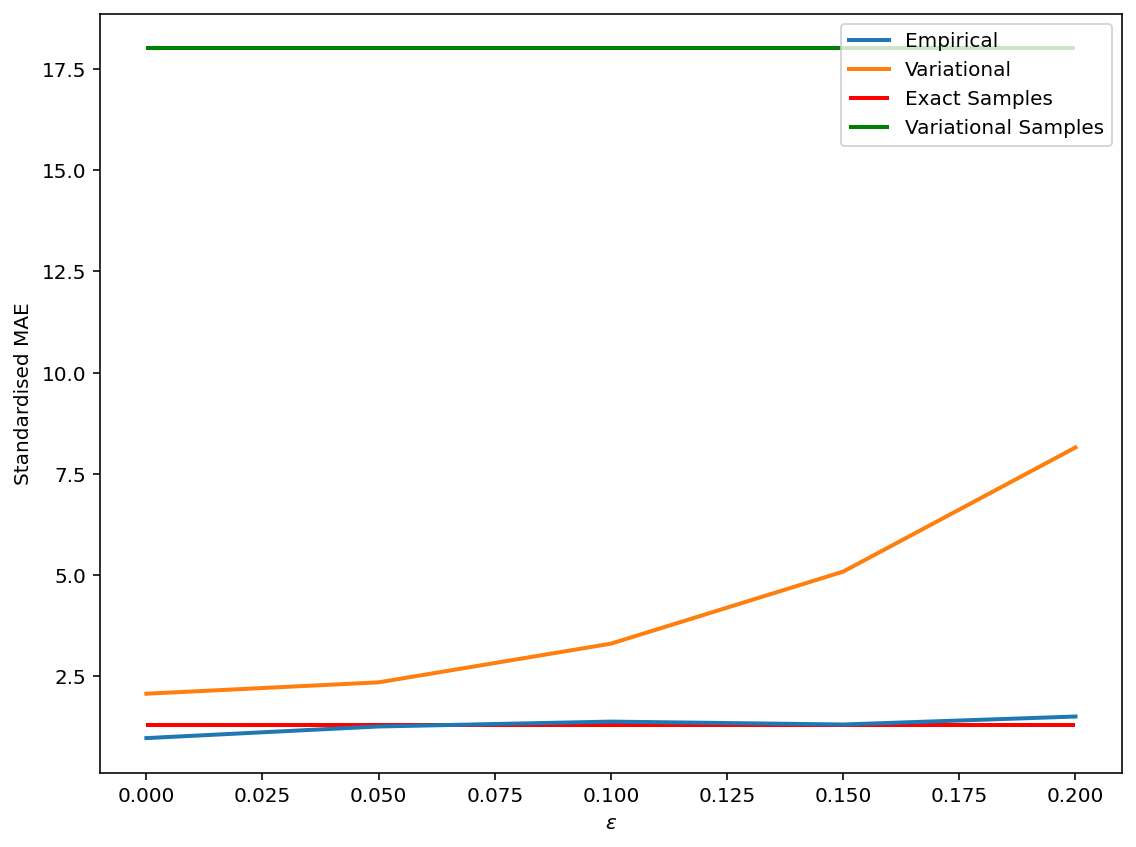

In [1630]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_mae, label='Empirical')
ax.plot(epsilons, vari_mae, label='Variational')
ax.hlines(exact_mae, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_mae, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised MAE')
ax.legend()
fig.tight_layout()

# Comparing to optimised vars

In [281]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 25
beamwidth = 1
emp = []
vari = []
emp_opt = []
vari_opt = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    vari_opt.append(pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp_opt.append(pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [282]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [283]:
b.signal_std

0.1

In [284]:
exact_log_probs = make_gmm(true_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [285]:
exact_var_log_probs = make_gmm(var_approx_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [286]:
exact_var_log_probs

tensor([-22268.4343])

In [287]:
exact_log_probs

tensor([-1329.7996])

In [288]:
vari_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [289]:
vari_opt_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_opt_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_opt_full_preds[i] = compute_preds(emp_opt[i], b)
    vari_opt_full_preds[i] = compute_preds(vari_opt[i], b)

In [290]:
var_gmm = make_gmm(vari_full_preds, signal_std=b.signal_std)
var_log_probs = var_gmm.log_prob(b.regression_targets_test)

emp_gmm = make_gmm(emp_full_preds, signal_std=b.signal_std)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test)

In [291]:
var_opt_gmm = make_gmm(vari_opt_full_preds, signal_std=b.signal_std)
var_opt_log_probs = var_opt_gmm.log_prob(b.regression_targets_test)

emp_opt_gmm = make_gmm(emp_opt_full_preds, signal_std=b.signal_std)
emp_opt_log_probs = emp_opt_gmm.log_prob(b.regression_targets_test)

In [292]:
emp_log_probs

tensor([-7381.9580, -3875.9814, -4493.6242, -5860.9365, -1812.9581])

In [293]:
emp_opt_log_probs

tensor([-3985.3235, -2683.8350, -4027.3923, -5462.0480, -2204.3583])

In [294]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=signal_std).log_prob(b.regression_targets_test))

NameError: name 'signal_std' is not defined

In [295]:
map_log_likelihood

NameError: name 'map_log_likelihood' is not defined

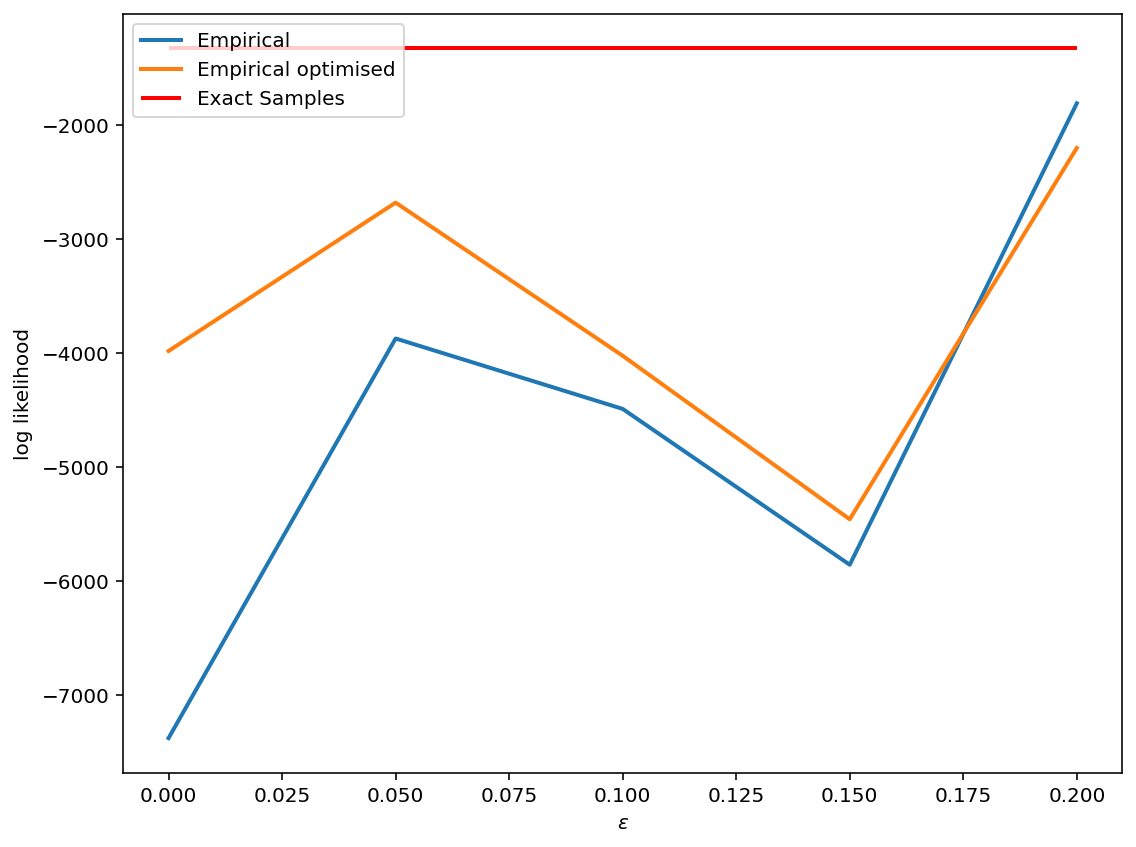

In [296]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs, label='Empirical')
ax.plot(epsilons, emp_opt_log_probs, label='Empirical optimised')
# ax.plot(epsilons, var_log_probs, label='Variational')
ax.hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
# ax.hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

##### from rec.utils import compute_variational_posterior

In [ ]:
true_post = dist.MultivariateNormal(loc=torch.tensor(emp[-1]['target_mean']), covariance_matrix=torch.tensor(emp[-1]['target_covar']))

In [ ]:
var_approx = compute_variational_posterior(dist.MultivariateNormal(loc=torch.tensor(emp[-1]['target_mean']), covariance_matrix=torch.tensor(emp[-1]['target_covar'])))

In [ ]:
import numpy as np

In [ ]:
dim = 25

In [ ]:
aux_vars_emp = pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/optimised_vars_emp.pkl", "rb")).numpy()
aux_vars_var = pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/optimised_vars_var.pkl", "rb")).numpy()

In [ ]:
def compute_power_rule(aux_vars, power_rule_exponent, var=1):
    sigmas = torch.zeros_like(torch.tensor(aux_vars))
    sigma_idxs = torch.arange(1, len(aux_vars)+1)
    for i, idx in enumerate(sigma_idxs):
        sigmas[i] = (var - torch.sum(sigmas[:i])) * (len(aux_vars) + 1 - idx) ** (-1 * power_rule_exponent)
    return sigmas

def compute_slope(aux_vars):
    ks = np.arange(1, len(aux_vars) + 1)
    A = np.vstack([ks, np.ones(len(ks))]).T
    m, c = np.linalg.lstsq(A, aux_vars, rcond=None)[0]
    return m,c

def compute_sigmas(m, c, n_aux):
    sigmas = [np.exp(x * m + c) for x in range(1, n_aux + 1)]
    return np.array(sigmas)

def compute_sigmas_from_optimised(aux_vars):
    # sample enough points to get a good trend, final points are noisy
    log_sigma_k = np.log(aux_vars[:len(aux_vars) // 2 + 1])
    m, c = compute_slope(log_sigma_k)
    un_normalised = compute_sigmas(m.round(2), c.round(2), len(aux_vars))
    return un_normalised / un_normalised.sum()

In [ ]:
plt.plot(aux_vars_emp, label = 'Empirical')
plt.plot(aux_vars_var, label= 'Variational')
plt.yscale("log")
plt.legend()

In [ ]:
compute_sigmas_from_optimised(aux_vars_emp).sum()

In [ ]:
aux_vars_emp

In [ ]:
plt.plot(compute_sigmas_from_optimised(aux_vars_emp))
plt.plot(aux_vars_emp)

In [ ]:
for dim in [2, 5, 8, 10, 20, 25, 30, 40, 50, 75, 90]:
    aux_vars_emp = pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/optimised_vars_emp.pkl", "rb")).numpy()
    aux_vars_var = pkl.load(open(f"PickledStuff/Correlated/Dim{dim}/optimised_vars_var.pkl", "rb")).numpy()
    approx_emp = compute_sigmas_from_optimised(aux_vars_emp)
    approx_var = compute_sigmas_from_optimised(aux_vars_var)
    pkl.dump(approx_emp, open(f"PickledStuff/Correlated/Dim{dim}/approx_vars_emp.pkl", "wb")) 
    pkl.dump(approx_var, open(f"PickledStuff/Correlated/Dim{dim}/approx_vars_var.pkl", "wb")) 